# Code for fig4

In [1]:
## imports (generic)
import os
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular' # to use latex math symbols like mu

## Prepare inputs

In [2]:
## input data from peat_exp_analysis/v25, copied in folder ../data
path_data = '../data'
## set path for storing the figure made by this file
path_fig = '../fig'

In [3]:
# read in the data - result from experiment v14
## OSCAR output w/ peatlands - tier2 scenarios
TMP = xr.open_dataset(path_data + '/OUT_cut_scen_tier2_peat_calc_stat_drop.nc')
ds_calc = TMP.copy(deep=True) 
## OSCAR output w/peatlands - SSP scenarios
TMP = xr.open_dataset(path_data + '/OUT_cut_scen_peat_calc_stat.nc')
ds_calc_ssp = TMP.copy(deep=True) 
## OSCAR output w/o peatlands - tier2 scenarios
TMP = xr.open_dataset(path_data + '/OUT_cut_scen_tier2_calc_stat_drop.nc')
ds_calc_nonpeat = TMP.copy(deep=True) 
## OSCAR output w/o peatlands - SSP scenarios
TMP = xr.open_dataset(path_data + '/OUT_cut_scen_calc_stat.nc')
ds_calc_ssp_nonpeat = TMP.copy(deep=True) 

In [4]:
folder_data = path_data
## mask to filter out negative scenarios from input
TMP = xr.open_dataset(folder_data + '/ds_subset_mask.nc')
ds_eff_mask = TMP.copy(deep=True)
## mask to filter out negative scenarios from output
TMP = xr.open_dataset(folder_data + '/ds_dco2_mask.nc')
ds_dco2_mask = TMP.copy(deep=True)
## non-overshoot related calculations
TMP = xr.open_dataset(folder_data + '/ds_calc_nov.nc')
ds_calc_nov = TMP.copy(deep=True)
TMP = xr.open_dataset(folder_data + '/ds_calc_nov_pt.nc')
ds_calc_nov_pt = TMP.copy(deep=True)
TMP = xr.open_dataset(folder_data + '/ds_calc_nov_pt_obelix.nc')
ds_calc_nov_pt_obelix = TMP.copy(deep=True)
# make a mask for selecting non-extreme values
mask_scen = ds_dco2_mask['mask_dco2'].drop(['year','var_name'])
mask_tg = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg') <= 200
mask_co2 = ds_calc_nov_pt['best_guess'].sel(var_name='D_CO2') <= 3000
mask_ept_co2 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2') <= 0.07

# Combine the masks using logical OR to check if any criteria is met along the 'scen' dimension, including all four masks above
combined_mask = ~((~mask_tg).any(dim='year') & (~mask_co2).any(dim='year') & (~mask_ept_co2).any(dim='year')).drop('var_name')
combined_mask = combined_mask.where(mask_scen, drop=True)

In [5]:
TMP = xr.open_dataset(folder_data + '/stat_OS.nc')
ds_stat = TMP.copy(deep=True) 
# import
TMP = xr.open_dataset(folder_data + '/stat_OS_pt.nc')
ds_stat_pt = TMP.copy(deep=True) 

In [6]:
# read in data for plot4
TMP = xr.open_dataset(folder_data + '/ds_captive_budget.nc')
ds_out = TMP.copy(deep=True)

## Plotting

## color choices

In [7]:
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88','#ff9857', '#e77b2e', '#ffbcaf', '#f4777f', '#cf3759', '#93003a']
col_targetT = {1.5:'#4771b2',
               2.: '#a5d5d8', 
               2.5: '#ff9857', 
               3.0: '#cf3759'} 

col_txt = 'black'
col_txt_dsk = {1.5:'#00429d', 
               2.: '#73a2c6', 
               2.5: '#e77b2e', 
               3.0: '#93003a'}

In [8]:
## define the target temperature
tgt_lst = [1.5,2,2.5]
## filter out ds_calc with combined_mask
ds_calc = ds_calc.where(combined_mask, drop=True)
ds_calc_nonpeat = ds_calc_nonpeat.where(combined_mask, drop=True)

## Make subplots

Remove scenarios not used in analysis

In [9]:
# combine ds_calc and ds_calc_ssp and remove 'SSP5-8.5' scenario
ds_calc = xr.concat([ds_calc, ds_calc_ssp], dim='scen')
ds_calc_nonpeat = xr.concat([ds_calc_nonpeat, ds_calc_ssp_nonpeat], dim='scen')

In [10]:
# remove SSP5-8.5 scenario from analysis (was only used in analysis up tp 2100)
ds_calc = ds_calc.where(ds_calc['scen'] != 'SSP5-8.5', drop=True)

In [11]:
# also remove 'SSP3-7.0-LowNTCF' scenario from ds_calc and ds_calc_nonpeat
ds_calc = ds_calc.where(ds_calc['scen'] != 'SSP3-7.0-LowNTCF', drop=True)
ds_calc_nonpeat = ds_calc_nonpeat.where(ds_calc_nonpeat['scen'] != 'SSP3-7.0-LowNTCF', drop=True)

### plot 1

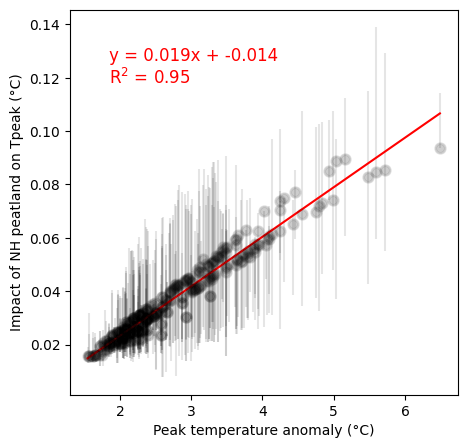

In [18]:
t_impact = ds_calc.Tpeak_bg - ds_calc_nonpeat.Tpeak_bg
t_impact_16 = ds_calc.Tpeak_per.sel(percentile=16)-ds_calc_nonpeat.Tpeak_per.sel(percentile=16)
t_impact_84 = ds_calc.Tpeak_per.sel(percentile=84)-ds_calc_nonpeat.Tpeak_per.sel(percentile=84)
plt.figure(figsize=(5., 5.))
yerr_lower = np.clip(t_impact - t_impact_16, 0, None)
yerr_upper = np.clip(t_impact_84 - t_impact, 0, None)

plt.errorbar(x=ds_calc.Tpeak_bg, y=t_impact, yerr=[yerr_lower, yerr_upper], 
             label='68th percentile', capsize=0, alpha=0.1, markeredgecolor='k', markersize=8, color='k',  fmt='o')
plt.scatter(ds_calc.Tpeak_bg,t_impact, color = 'k', alpha = 0.1)

# Linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(ds_calc.Tpeak_bg, t_impact)
x_values = np.linspace(ds_calc.Tpeak_bg.min(), ds_calc.Tpeak_bg.max(), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='red')
# R-squared and equation
equation = f'y = {slope:.3f}x + {intercept:.3f}'
r_squared = f'R$^2$ = {r_value**2:.2f}'
# add the text to the plot
plt.text(0.1, 0.85, f'{equation}\n{r_squared}', fontsize=12, 
         ha='left', va='center', color='r', transform=plt.gca().transAxes, zorder=10)

plt.xlabel('Peak temperature anomaly (\u00B0C)')
plt.ylabel('Impact of NH peatland on Tpeak (\u00B0C)')

plt.savefig(path_fig+'/sub_fig4_impact_Tpeak.png', dpi=300, bbox_inches='tight')

### plot 2

In [21]:
# processing data for plotting
markers = {0.2: 'o', 0.4: 'v', 0.6: 's', 0.8: '^',1: 'o',1.5: 'o'}
os_list = [0.2,0.4,0.6,0.8] # Get the unique OS values - limit the range to used ones
tgt_list = list([1.5, 2.0, 2.5])
x_offset = {0.2: -0.06, 0.4: -0.02, 0.6: 0.02, 0.8: 0.06, } # Define the x offset for each OS
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88', '#ffbcaf', '#f4777f', '#cf3759', '#93003a'] 
col_os_dsk = {0.2: '#4771b2', 0.4: '#a5d5d8', 0.6: '#ffcc88', 0.8: '#f4777f', 1.0:'#cf3759'} 
col_tgt_dsk = {1.5: '#4771b2', 2.0: '#ffcc88', 2.5: '#cf3759'} 

# plotting
ds_plt = ds_stat[['Tpeak_bg','Tpeak_per','yr_last_bg','yr_first_bg','yr_last_per','yr_first_per','osl_msk_bg','osl_msk_per']]
ds_plt['ov_period_bg'] = ds_plt.yr_last_bg - ds_plt.yr_first_bg
ds_plt['ov_period_per'] = ds_plt.yr_last_per - ds_plt.yr_first_per

ds_plt_pt = ds_stat_pt[['Tpeak_bg','Tpeak_per','yr_last_bg','yr_first_bg','yr_last_per','yr_first_per','osl_msk_bg','osl_msk_per']]
ds_plt_pt['ov_period_bg'] = ds_plt_pt.yr_last_bg - ds_plt_pt.yr_first_bg
ds_plt_pt['ov_period_per'] = ds_plt_pt.yr_last_per - ds_plt_pt.yr_first_per

# make a mask for selecting non-extreme values
mask_tg = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg') <= 200
mask_co2 = ds_calc_nov_pt['best_guess'].sel(var_name='D_CO2') <= 3000
mask_ept_co2 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2') <= 0.07

# Combine the masks using logical OR to check if any criteria is met along the 'scen' dimension
combined_mask = ~((~mask_tg).any(dim='year') & (~mask_co2).any(dim='year') & (~mask_ept_co2).any(dim='year')).drop('var_name')

## masked plots
ds_plt = ds_plt.where(combined_mask, drop=True)
ds_plt_pt = ds_plt_pt.where(combined_mask, drop=True)


In [22]:
ds_plt= ds_plt.sel(scen=ds_plt['scen'].isin(ds_calc['scen']))
ds_plt_pt= ds_plt_pt.sel(scen=ds_plt_pt['scen'].isin(ds_calc['scen']))

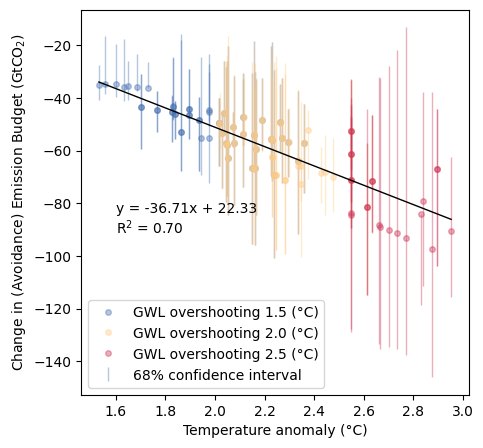

In [24]:
####################
### budget reduction total absolute - one trendline
####################
# plot - budget reduction total absolute - one trendline
TCRE = 1000/1.65/12*44 #1.65°C per 1000 PgC(GtCO2), IPCC AR6, (1.65°C EgC–1)
budget_base = {1.5:297,1.6:498,1.7:663,1.8:847,1.9:1058, 2.0:1265,2.1:1480,2.2:1698,2.3:1911,2.4:2127,2.5:2346} 
# from Lamboll, R. Assessing the size and uncertainty of remaining carbon budgets
# list all possibilities
fig, ax = plt.subplots(figsize=(5., 5.))
# create the plot and errorbar handles and assign them to variables
plot_handles = []
errorbar_handles = []
# physical uncertainty
for tgt in tgt_list:
    for sn_index,sn in enumerate(ds_plt.scen):
        # for best guess - average of configurations
        data = ds_plt.sel(target_T=tgt).sel(scen=sn)
        data_pt = ds_plt_pt.sel(target_T=tgt).sel(scen=sn)
        x = data.Tpeak_bg 
        if x>=tgt:
            if not np.isnan(data.ov_period_bg):
                y_change = data_pt['Tpeak_bg']-data['Tpeak_bg']
                y = y_change*TCRE
            
                p84 = (data_pt['Tpeak_per'].sel(percentile=84)-data['Tpeak_per'].sel(percentile=84)).values
                p16 = (data_pt['Tpeak_per'].sel(percentile=16)-data['Tpeak_per'].sel(percentile=16)).values 
                
                # plot each point and add label when sn_index==10
                plt_handle = ax.plot(x, -y, marker = 'o', alpha=0.4, color=col_tgt_dsk[tgt], markeredgecolor=col_tgt_dsk[tgt], markersize=4, linewidth = 0,
                                     label = f'GWL overshooting {tgt} (\u00B0C)')[0]
                
                yerr_lower = np.clip(y-p16*TCRE, 0, None)
                yerr_upper = np.clip(p84*TCRE-y, 0, None)
                # Assuming 'x' and 'y' are 1D arrays, you can convert 'yerr_lower' and 'yerr_upper' to the correct shape
                yerr = np.vstack([yerr_lower, yerr_upper])

                errorbar_handle = ax.errorbar(x=x, y=-y, yerr=yerr, label='68% confidence interval' if tgt == 1.5 else None,
                             capsize=0, alpha=0.4, color=col_tgt_dsk[tgt], markeredgecolor=col_tgt_dsk[tgt], markersize=8, linewidth=1, linestyle='')

    if tgt==1.5:
        errorbar_handles.append(errorbar_handle)
    plot_handles.append(plt_handle)  
    
    ## Calculate the trend line using linear regression
    data = ds_plt.sel(target_T=tgt)
    data_pt = ds_plt_pt.sel(target_T=tgt)
    # Create a boolean mask to check if ov_period_bg is not NaN
    mask_not_nan = ~np.isnan(data['ov_period_bg'])
    # Use the mask to filter Tpeak_bg values
    x = data['Tpeak_bg'][mask_not_nan]
    y_change = (data_pt['Tpeak_bg']-data['Tpeak_bg'])[mask_not_nan]
    y = -y_change*TCRE

    # combine all x and y values for all tgt
    if tgt==1.5:
        x_all = x
        y_all = y
    else:
        x_all = np.concatenate((x_all,x))
        y_all = np.concatenate((y_all,y))
    
    if tgt==2.5:
        # Fit a linear regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_all,y_all)
        x_values = np.linspace(x_all.min(), x_all.max(), 100)
        y_values = slope * x_values + intercept
        plt.plot(x_values, y_values, color='black', linewidth=1)
        # R-squared and equation
        equation = f'y = {slope:.2f}x + {intercept:.2f}'
        r_squared = f'R$^2$ = {r_value**2:.2f}'
        # add the text to the plot
        plt.text(1.6, np.min(y_values), f'{equation}\n{r_squared}', fontsize=10, ha='left', va='center', color='black', zorder=10)


# Add the combined legend to the plot
#ax.legend(combined_handles, combined_labels, loc='lower left', bbox_to_anchor=(0., 0.15))
ax.legend(handles=plot_handles + errorbar_handles, loc='lower left')

# Set the x-tick labels, axis labels, and other settings as needed
ax.set_xlabel('Temperature anomaly (\u00B0C)')
ax.set_ylabel('Change in (Avoidance) Emission Budget (GtCO$_2$)')
ax.grid(False)

plt.savefig(path_fig+'/sub_fig4_remaining_budget_reduction_oneline.png', dpi = 300, bbox_inches='tight')

### plot 3

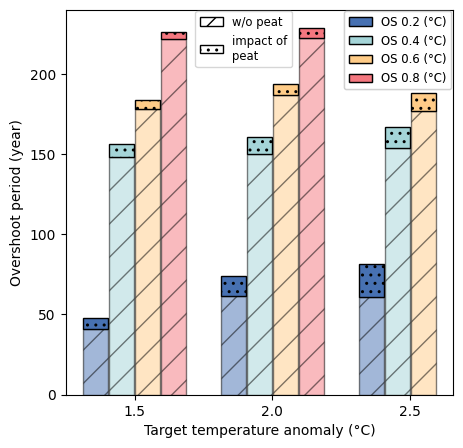

In [25]:
x_offset = {0.2: -0.141, 0.4: -0.047, 0.6: 0.047, 0.8: 0.141} # Define the x offset for each OS
# length absolute reduction
plt.figure(figsize=(5, 5))
# Plot the bars
for os in os_list:
    # for best guess - average of configurations
    data = ds_plt.where(ds_plt.osl_msk_bg==1).sel(target_T=[1.5, 2.0, 2.5],OS=os)
    data_pt = ds_plt_pt.where(ds_plt_pt.osl_msk_bg==1).sel(target_T=[1.5, 2.0, 2.5],OS=os)
    x = data_pt['target_T'].values + x_offset[os]
    y = data_pt['ov_period_bg'].mean('scen')
    y_change = (data_pt['ov_period_bg']-data['ov_period_bg']).mean('scen')
    
    plt.bar(x=x, height= y, color=col_os_dsk[os], width=0.09, hatch='/', label=f"OS {os} (\u00B0C)",edgecolor = 'black',alpha=0.5)
    plt.bar(x=x, height= y_change, color= col_os_dsk[os], width=0.09, hatch='..', bottom=y,edgecolor = 'black', alpha = 1)
    #plt.bar(x=x, height= y_change, color= col_os_dsk[os], width=0.09, hatch='..', bottom=y,edgecolor = 'brown', fill=False)
## for self-defined legend (two legend seperated)
import matplotlib.patches as mpatches
# Create the hatch legend
hatch_legend = plt.legend(handles=[mpatches.Patch(facecolor='white', edgecolor='black', hatch='//'),
                                   mpatches.Patch(facecolor='white', edgecolor='black', hatch='..')],
                          labels=['w/o peat', 'impact of\npeat'],
                          loc='upper right',bbox_to_anchor=(0.6,1.012),fontsize='small')
# Create the OS legend
os_legend = plt.legend(handles=[mpatches.Patch(facecolor=col_os_dsk[0.2], edgecolor='black'),
                                mpatches.Patch(facecolor=col_os_dsk[0.4], edgecolor='black'),
                                mpatches.Patch(facecolor=col_os_dsk[0.6], edgecolor='black'),
                                mpatches.Patch(facecolor=col_os_dsk[0.8], edgecolor='black')],
                       labels=['OS 0.2 (\u00B0C)', 'OS 0.4 (\u00B0C)', 'OS 0.6 (\u00B0C)', 'OS 0.8 (\u00B0C)'],
                       loc='upper right',bbox_to_anchor=(1.01,1.012),fontsize='small')
# Add both legends to the plot using add_artist
plt.gca().add_artist(hatch_legend)
plt.gca().add_artist(os_legend)
#plt.legend(loc='upper right')
plt.xlabel('Target temperature anomaly (\u00B0C)')
plt.ylabel('Overshoot period (year)')
# Set the x-tick labels to only show the values in the data
plt.xticks([1.5, 2.0, 2.5])
plt.savefig(path_fig+"/sub_fig4_length_reduction_absolute_bar.png", dpi=300, bbox_inches='tight')



### plot 4

In [12]:
ds_stat= ds_stat.sel(scen=ds_stat['scen'].isin(ds_calc['scen']))
ds_stat_pt= ds_stat_pt.sel(scen=ds_stat_pt['scen'].isin(ds_calc['scen']))

### data preparation

In [13]:
################################################
### Define the markers for each "OS" value
################################################
markers = {0.2: 'o', 0.4: 'v', 0.6: 's', 0.8: '^',1: 'o',1.5: 'o'}
os_list = [0.2,0.4,0.6,0.8] # Get the unique OS values - limit the range to used ones
tgt_list = list([1.5, 2.0, 2.5])
x_offset = {0.2: -0.06, 0.4: -0.02, 0.6: 0.02, 0.8: 0.06, } # Define the x offset for each OS
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88', '#ffbcaf', '#f4777f', '#cf3759', '#93003a'] 
col_os_dsk = {0.2: '#4771b2', 0.4: '#a5d5d8', 0.6: '#ffcc88', 0.8: '#f4777f', 1.0:'#cf3759'} 
# plotting
ds_plt = ds_stat[['Tpeak_bg','Tpeak_per','yr_last_bg','yr_first_bg','yr_last_per','yr_first_per','osl_msk_bg','osl_msk_per']]
ds_plt['ov_period_bg'] = ds_plt.yr_last_bg - ds_plt.yr_first_bg
ds_plt['ov_period_per'] = ds_plt.yr_last_per - ds_plt.yr_first_per


In [14]:
ds_out

<xarray.Dataset>
Dimensions:       (scen: 297, target_T: 4, source: 4, OS: 5, percentile: 7)
Coordinates:
  * scen          (scen) object 'SSP1-1.9' ... 'SSP5-Baseline_ConstUntil2050_...
  * target_T      (target_T) float64 1.5 2.0 2.5 3.0
  * percentile    (percentile) float64 0.15 99.85 2.5 97.5 16.0 84.0 50.0
  * source        (source) object 'tier2' 'tier2_peat' 'ssp' 'ssp_peat'
  * OS            (OS) float64 0.2 0.4 0.6 0.8 1.0
Data variables:
    cum_eco2_bg   (scen, target_T, source, OS) float64 ...
    cum_eco2_per  (scen, target_T, percentile, source, OS) float64 ...
    osl_msk_bg    (source, scen, target_T, OS) float32 ...
    osl_msk_per   (source, scen, target_T, OS, percentile) float32 ...

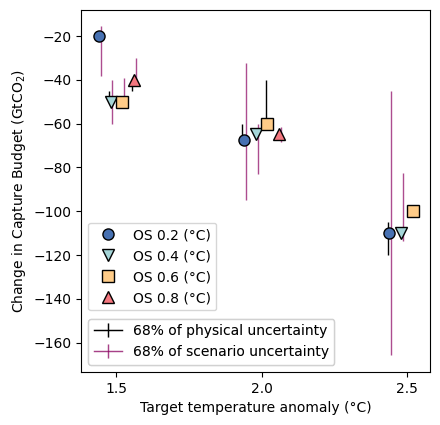

In [24]:
####################
### budget reduction overshoot absolute
####################
# plot - budget reduction captive
fig, ax = plt.subplots(figsize=(4.5, 4.7))
# create the plot and errorbar handles and assign them to variables
plot_handles = []
errorbar_handles = []
#region physical uncertainty
for os in os_list:
    for tgt_T in tgt_list:
    # for best guess - average of configurations
        data = ds_out.where(ds_out.osl_msk_bg==1).sel(target_T=tgt_T,OS=os)
        x = tgt_T + x_offset[os] 
        y_change = (data['cum_eco2_bg'].sel(source='tier2_peat')-data['cum_eco2_bg'].sel(source='tier2')).dropna(dim='scen')
        y = y_change.median('scen')
    # for percentiles - configuration uncertainty
        p84 = (ds_out['cum_eco2_per'].sel(source='tier2_peat',percentile=84,target_T=tgt_T,OS=os)-ds_out['cum_eco2_per'].sel(source='tier2',percentile=84,target_T=tgt_T,OS=os)).dropna(dim='scen').median('scen').drop('percentile')
        p16 = (ds_out['cum_eco2_per'].sel(source='tier2_peat',percentile=16,target_T=tgt_T,OS=os)-ds_out['cum_eco2_per'].sel(source='tier2',percentile=16,target_T=tgt_T,OS=os)).dropna(dim='scen').median('scen').drop('percentile')
        #errorbar_handle = ax.errorbar(x=x-0.006, y=y, yerr=[[y-p16], [p84-y]],label = f'68% of physical uncertainty' if os==0.2 else None,
                   # capsize=0, alpha=0.4, color=col_os_dsk[os], markeredgecolor='k', markersize=8, linewidth=1)
        lwr = np.maximum(y.values- p84.values, 0)
        upr = np.maximum(p16.values - y.values, 0)
        # create a 2D array for yerr
        yerr = np.array([[lwr], [upr]])
        errorbar_handle = ax.errorbar(x=x-0.006, y=y.values, yerr=yerr,label = f'68% of physical uncertainty' if os==0.2 else None,
                    capsize=0, alpha=1, color='black', markeredgecolor='k', markersize=8, linewidth=1)
        if tgt_T==1.5 and os == 0.2:
            errorbar_handles.append(errorbar_handle)
#plt.show()
#endregion
#region scenario uncertainty
for os in os_list:
    for tgt_T in tgt_list:
        # for best guess - average of configurations
        data = ds_out.where(ds_out.osl_msk_bg==1).sel(target_T=tgt_T,OS=os)
        x = tgt_T + x_offset[os]
        y_change = (data['cum_eco2_bg'].sel(source='tier2_peat')-data['cum_eco2_bg'].sel(source='tier2')).dropna(dim='scen')
        if len(y_change)>0:
            y = y_change.median('scen')

            p84 = np.percentile(y_change, 84,axis=0)
            p16 = np.percentile(y_change, 16,axis=0)
            
            errorbar_handle = ax.errorbar(x=x+0.006, y=y, yerr=[[y-p16], [p84-y]],label = f'68% of scenario uncertainty' if os==0.2 else None,
                                    capsize=0, alpha=0.7, color='#8a0060', markeredgecolor='k', markersize=8, linewidth=1)
            
            plt_handle = ax.plot(x, y, markers[os]+'-', alpha=1, color=col_os_dsk[os], markeredgecolor='k', markersize=8, linewidth = 0,
                                label = f'OS {os} (\u00B0C)' if tgt_T==1.5 else None)[0]

            if tgt_T==1.5:
                plot_handles.append(plt_handle)            
            if tgt_T==1.5 and os ==0.2:
                errorbar_handles.insert(1, errorbar_handle)
#endregion
#region other settings
# create separate legend boxes for the plot and errorbar handles
legend1 = ax.legend(handles=plot_handles, loc='lower left',bbox_to_anchor=(0.,0.15))
legend2 = ax.legend(handles=errorbar_handles, loc='lower left',bbox_to_anchor=(0.,0))
# add the legend boxes to the plot
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('Target temperature anomaly (\u00B0C)')
ax.set_ylabel('Change in Capture Budget (GtCO$_2$)')
# remove grid
ax.grid(False)
# Set the x-tick labels to only show the values in the data
ax.set_xticks(tgt_list,minor = False)
ax.set_xticklabels(tgt_list)
#endregion
# Save the figure
plt.savefig(path_fig+'/sub_fig4_budget_reduction_overshoot_absolute_elucadded.png', dpi=300, bbox_inches='tight')

## combine plots

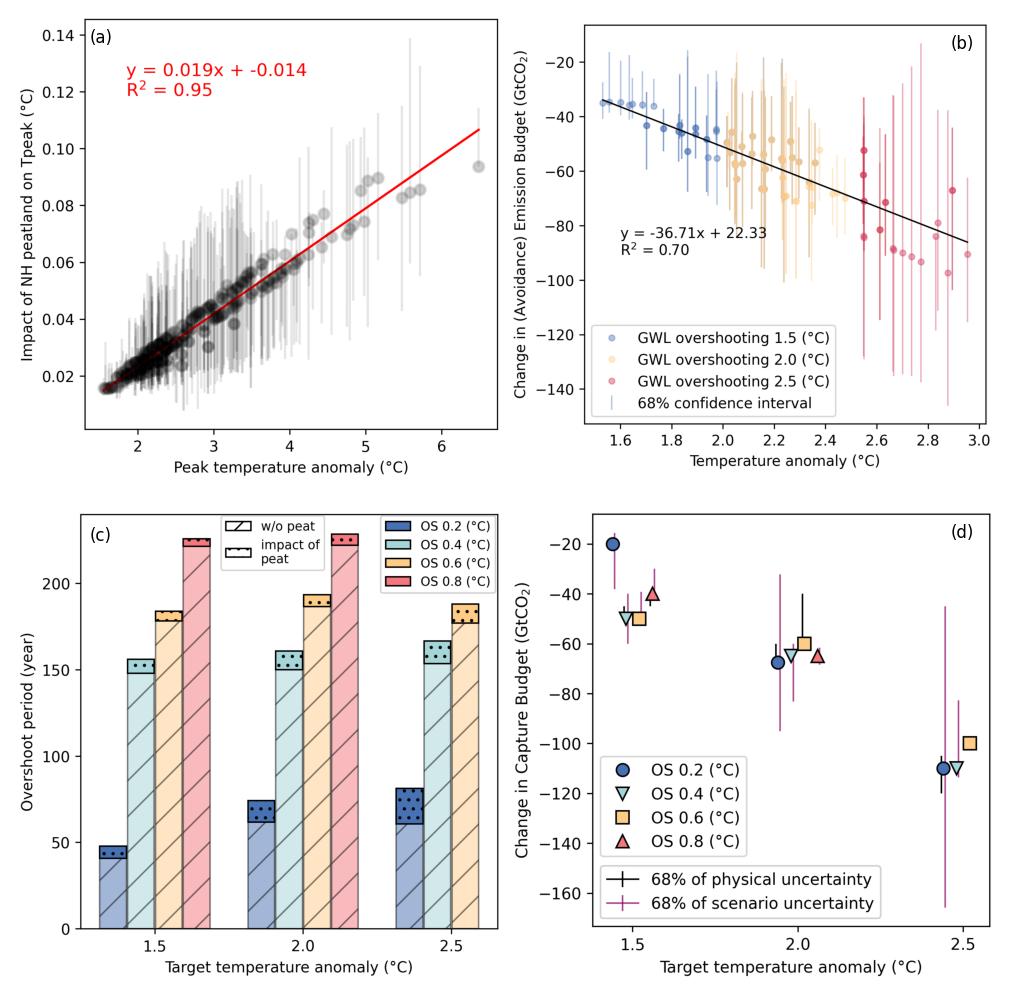

In [26]:
from PIL import Image

# Load the four PNG images
img1 = Image.open(path_fig + '/sub_fig4_impact_Tpeak.png')
img2 = Image.open(path_fig + '/sub_fig4_remaining_budget_reduction_oneline.png')
img3 = Image.open(path_fig + '/sub_fig4_length_reduction_absolute_bar.png')
img4 = Image.open(path_fig + '/sub_fig4_budget_reduction_overshoot_absolute_elucadded.png')

# Set the figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Load each image into the corresponding subplot
axes[0, 0].imshow(img1)
axes[0, 1].imshow(img2)
axes[1, 0].imshow(img3)
axes[1, 1].imshow(img4)

# Set the axis labels to off for all subplots
for ax in axes.flat:
    ax.set_axis_off()

# Add labels (a), (b), (c), (d) to the subplots
axes[0, 0].text(0.16, 0.93, '(a)', transform=axes[0, 0].transAxes, fontsize=12)
axes[0, 1].text(0.9, 0.93, '(b)', transform=axes[0, 1].transAxes, fontsize=12)
axes[1, 0].text(0.16, 0.925, '(c)', transform=axes[1, 0].transAxes, fontsize=12)
axes[1, 1].text(0.9, 0.93, '(d)', transform=axes[1, 1].transAxes, fontsize=12)


# Set the spacing between subplots to 0
fig.subplots_adjust( top = 1, bottom = 0,left=0.02, right=1.01, hspace=-0.01, wspace=-0.01)
# Save the figure to png
plt.savefig(path_fig+'/figure4.png', dpi=300, bbox_inches='tight')
# Save the figure to pdf
plt.savefig(path_fig+'/figure4.pdf', dpi=300, bbox_inches='tight')